In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("C:\\Users\\11ani\\OneDrive\\Desktop\\project 7th sem code\\clean_comments\\traindata\\traindata.csv", index_col=[0])
data = data.reset_index(drop=True)
data

,comments,sentiments,clean_comments
0,What I'm going to say is that I never imagined...,0,im go say never imagine member nation finest t...
1,Please continue this series. What happened aft...,1,please continue series happen rana collapse lo...
2,"Would love to see more of our history's video,...",1,would love see historys video brother hugely r...
3,They will never be forgotten. Salute to our ma...,1,never forget salute martyr
4,"The level of editing , animation , voice, rese...",1,level edit animation voice research everything...
...,...,...,...
3759,Rahar le gako ho bro tya Bhadyata t khadi ho,0,rahar le gako ho bro tya bhadyata khadi ho
3760,"Ramrari padha kta ho, ramro jaagir khau, sano ...",0,ramrari padha kta ho ramro jaagir khau sano ti...
3761,Bhai esto video banaayera Nepali ko beijat nag...,0,bhai esto video banaayera nepali ko beijat nag...
3762,यो सब bramanbad ley garda हो... Fuc...... Off...,0,bramanbad ley garda fuc braman


In [44]:

length = len(data)  # finding out length of the datframe
pos_count = len(data[data['sentiments'] == 1])  # counting positive_sentiments
neg_count = len(data[data['sentiments'] == 0])  # counting negative_sentiments
print ('length=',length,'\npos_count',pos_count,'\nneg_count',neg_count,)

length= 3764 
pos_count 2583 
neg_count 1181


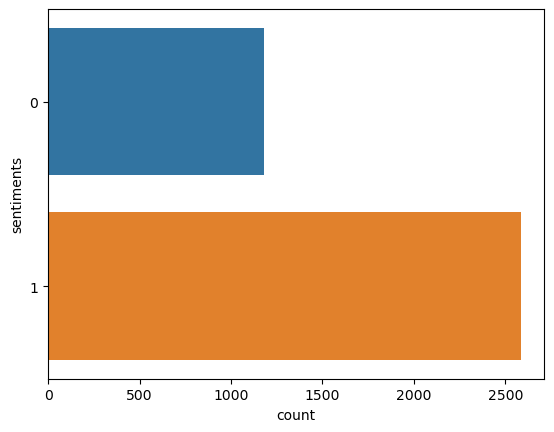

In [45]:


sns.countplot(y="sentiments",data=data)#plotting the data
plt.show()

In [46]:

def sentence_to_words(sentence):

    l = sentence.split()  # split sentence into individual word(tokanize)
    p = ''
    word_list = []

    for word in l:

        p = ''

        for letter in word:

            if ord(letter) >= 67 and ord(letter) <= 122:
                p = p + letter
        word_list.append(p)

    return word_list  # return the word list of the input comments
    

def naive_bayes_train(X, Y, a=0.000001):#a is laplace smoothing added to avoid overall prob being zero
    n_length = len(X)
    n_class_pos = len(Y[Y == 1])
    n_class_neg = len(Y[Y == 0])
    prior_pos = n_class_pos / n_length  # prior probability for  class
    prior_neg = n_class_neg / n_length  #prior probability for class 
    (n, p, bag) = bag_of_words_maker(X, Y)

    pr = {}

    for i in range(len(bag)):   #evaluating the likelihood prob for each word given a class
        p_pos = (bag['count_pos'][i] + a) / (p + len(bag) * a)

        p_neg = (bag['count_neg'][i] + a) / (n + len(bag) * a)

        pr[bag['index'][i]] = [p_pos, p_neg]
    pr = pd.DataFrame(pr).T
    pr.columns = ['sent=positive', 'sent=negative']
    pr = pr.reset_index()

    return (prior_pos, prior_neg, pr)

def naive_bayes_predict(X, pr, prior_pos, prior_neg):
    Y = []

    for i in range(len(X)):
        k_pos = 1
        k_neg = 1
        p = sentence_to_words(X[i])

        for k in range(len(pr)):

            for word in p:

                if word == pr['index'][k]:
                    k_pos = k_pos * pr['sent=positive'][k] #product of likelihood prob given the word is present in vocabulary 
                    k_neg = k_neg * pr['sent=negative'][k]

        
        nb = [prior_neg * k_neg, prior_pos * k_pos] # multiply each likelihood prob with the prior prob and find out which class prob is greater
        Y.append(np.argmax(nb))#sentence bvelongs to class with greater prob

    return Y

def bag_of_words_maker(X, Y):

    bag_dict_binary_NB_pos = {} #keeping track of the positive class words
    bag_dict_binary_NB_neg = {} #keeping track of the negative class words
  
    for i in range(len(X)):
        p = sentence_to_words(X[i])
        sent = Y[i]
        x_pos = {}
        x_neg = {} #we intialize the dict every iteration so that it does not consider repititions .(Binary NB)

        if sent == 1:
            for word in p:

                if word in x_pos.keys():
                    x_pos[word] = [x_pos[word][0] + 1, x_pos[word][1]]  #word is the key and value stored is [count, sentiment]
                else:
                    x_pos[word] = [1, sent]

            for key in x_pos.keys():

                if key in bag_dict_binary_NB_pos.keys():
                    bag_dict_binary_NB_pos[key] = \
                        [bag_dict_binary_NB_pos[key][0] + 1,
                         bag_dict_binary_NB_pos[key][1]]
                else:

                    bag_dict_binary_NB_pos[key] = [1, sent]  #storing it in the final dict 

        if sent == 0:

            for word in p:
                if word in x_neg.keys():
                    x_neg[word] = [x_neg[word][0] + 1, x_neg[word][1]]
                else:
                    x_neg[word] = [1, sent]
            for key in x_neg.keys():
                if key in bag_dict_binary_NB_neg.keys():
                    bag_dict_binary_NB_neg[key] = \
                        [bag_dict_binary_NB_neg[key][0] + 1,
                         bag_dict_binary_NB_neg[key][1]]
                else:

                    bag_dict_binary_NB_neg[key] = [1, sent]

    # print(bag_dict_multi.keys())
    # returns the dataframe containg word count in each sentiment 
    neg_bag = pd.DataFrame(bag_dict_binary_NB_neg).T
    pos_bag = pd.DataFrame(bag_dict_binary_NB_pos).T

    neg_bag.columns = ['count_neg', 'sentiment_neg']
    pos_bag.columns = ['count_pos', 'sentiment_pos']
    neg_bag = neg_bag.reset_index()
    pos_bag = pos_bag.reset_index()
    n = len(neg_bag)
    p = len(pos_bag)
    bag_of_words = pd.merge(neg_bag, pos_bag, on=['index'], how='outer')
    bag_of_words['count_neg'] = bag_of_words['count_neg'].fillna(0)
    bag_of_words['count_pos'] = bag_of_words['count_pos'].fillna(0)
    bag_of_words['sentiment_neg'] = bag_of_words['sentiment_neg'].fillna(0)
    bag_of_words['sentiment_pos'] = bag_of_words['sentiment_pos'].fillna(1)

    return (n, p, bag_of_words)



In [47]:
x = data['clean_comments']
y = data['sentiments']
(n, p, bag_of_words) = bag_of_words_maker(x, y)
print (n, ' ', p)
bag_of_words

6103   4488


,index,count_neg,sentiment_neg,count_pos,sentiment_pos
0,im,6.0,0.0,28.0,1.0
1,go,51.0,0.0,100.0,1.0
2,say,36.0,0.0,44.0,1.0
3,never,30.0,0.0,30.0,1.0
4,imagine,3.0,0.0,10.0,1.0
...,...,...,...,...,...
8478,amaing,0.0,0.0,1.0,1.0
8479,bhutanese,0.0,0.0,1.0,1.0
8480,affert,0.0,0.0,1.0,1.0
8481,hinda,0.0,0.0,1.0,1.0


In [48]:

(prior_pos,prior_neg,table) = naive_bayes_train(x,y)
#saving it in bag of word as bag for later predection
#table.to_csv("bag.csv")

#saving prior value in csv for later use
dat = [prior_pos,prior_neg]
prior = pd.DataFrame(dat, columns=['prior'])
prior.to_csv("prior.csv")

x = prior.iloc[0]['prior']
y = prior.iloc[1]['prior']
print(x,y)


0.6862380446333688 0.31376195536663126


In [49]:

from sklearn.model_selection import train_test_split

X = data["clean_comments"]
Y = data["sentiments"]
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=42)#splitting comments into train 80% and test 20%

x_train = x_train.reset_index(drop=True)#dropping previous index from pandas dataframe
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

(prior_pos, prior_neg, bag) = naive_bayes_train(x_train,y_train)

y_predicted = naive_bayes_predict(x_test,bag,prior_pos,prior_neg)

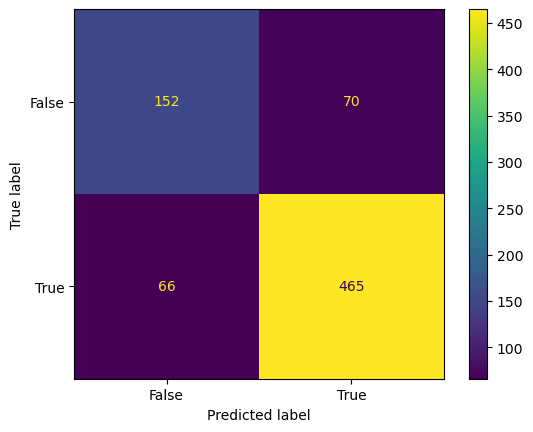

Accuracy= 0.8193891102257637
precsion= 0.8691588785046729
recall= 0.8757062146892656
flscore 0.8724202626641652


In [50]:
#getting accuracy of the model
from sklearn.metrics import confusion_matrix
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test,np.array(y_predicted))
(tn, fp, fn, tp) = confusion_matrix.ravel()

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

Accuracy = (tp + tn)/(tp + tn + fp + fn)
print ('Accuracy=', Accuracy)

precsion = tp / (tp + fp)
print ('precsion=', precsion)

recall = tp / (tp + fn)
print ('recall=', recall)

flscore = (2 * precsion * recall)/(precsion + recall)
print('flscore', flscore)


In [51]:
#looping for all videos
for i in range(1):
    #now predecting for youtube videos individually
    df = pd.read_csv("C:\\Users\\11ani\\OneDrive\\Desktop\\project 7th sem code\\clean_comments\\"+str(i)+'clean.csv', index_col=[0])
    
    Z = df['clean_comments']
    Z = Z.reset_index(drop=True)
    z_predicted = naive_bayes_predict(Z, bag, prior_pos, prior_neg)
    #z_predicted
    #saving predicted sentiments into dataframe and to csv
    df['sentiments'] = z_predicted
    df.to_csv("C:\\Users\\11ani\\OneDrive\Desktop\\project 7th sem code\\predected_comments\\"+str(i)+"predected.csv")
    print(df)


                                              comments  sentiments  \
0    Nepal was a leading country in material indust...           0   
1    I never knew we had such a early head start in...           1   
2    My dad owned a garment factory during that tim...           0   
3    Loved the video bro , you must now be consiste...           1   
4    Was garment industry the only industry in Nepa...           0   
..                                                 ...         ...   
171                                        haet....!!!           1   
172                                                HOR           1   
173                                               Ghjn           1   
174  Bro resham Chaudhary maa euta video banauna yo...           0   
176  Bro resham Chaudhary maa euta video banauna yo...           0   

                                        clean_comments  
0    nepal lead country material industry sad see c...  
1    never know early head start garment indu

length= 160 
pos_count 113 
neg_count 47
                                              comments  sentiments  \
0    Nepal was a leading country in material indust...           0   
1    I never knew we had such a early head start in...           1   
2    My dad owned a garment factory during that tim...           0   
3    Loved the video bro , you must now be consiste...           1   
4    Was garment industry the only industry in Nepa...           0   
..                                                 ...         ...   
171                                        haet....!!!           1   
172                                                HOR           1   
173                                               Ghjn           1   
174  Bro resham Chaudhary maa euta video banauna yo...           0   
176  Bro resham Chaudhary maa euta video banauna yo...           0   

                                        clean_comments  
0    nepal lead country material industry sad see c...  
1   

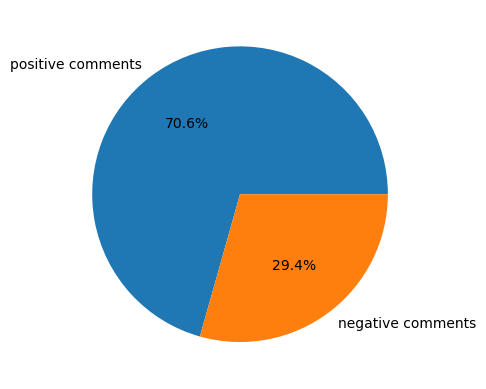

In [52]:
#analysis of comments
length = len(df)  # finding out length of the datframe
pos_count = len(df[df['sentiments'] == 1])  # counting positive_sentiments
neg_count = len(df[df['sentiments'] == 0])  # counting negative_sentiments
print ('length=',length,'\npos_count',pos_count,'\nneg_count',neg_count,)

y = np.array([pos_count,neg_count])
mylabels = ["positive comments", "negative comments"]
print(df)
plt.pie(y, labels= mylabels,  autopct='%1.1f%%')
plt.show() 